In [1]:
import numpy as np
import cv2
import os
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms, models
from tqdm import tqdm
import matplotlib.pyplot as plt
import rawpy
from utils import parse_anno_file, create_mask_file, big_image_predict

%matplotlib inline

In [2]:
path_to_data = 'asbest'
anno = parse_anno_file(os.path.join(path_to_data, 'tr_stones', 'annotation.xml'))

In [3]:
img_shape = (int(anno[0]['height']), int(anno[0]['width']))

In [4]:
len(anno)

26

In [6]:
from dataset import Asbest

In [7]:
train_data = Asbest(anno[:-5], crop_size=(img_shape[0] // 2, img_shape[1] // 2), img_size=(448, 448), num_frames=500, normalize=True)
valid_data = Asbest(anno[-5:], crop_size=(img_shape[0] // 2, img_shape[1] // 2), img_size=(448, 448), num_frames=100, normalize=True)

100%|██████████| 100/100 [00:11<00:00,  8.47it/s]


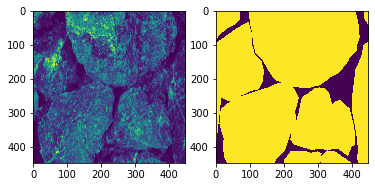

In [27]:
index = 73
plt.subplot(121)
plt.imshow(train_data.images[index])
plt.subplot(122)
plt.imshow(train_data.masks[index])

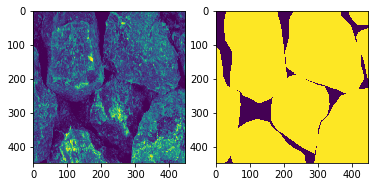

In [8]:
index = 31
plt.subplot(121)
plt.imshow(train_data.images[index])
plt.subplot(122)
plt.imshow(train_data.masks[index])

In [9]:
class AverageMeter(object):
    def __init__(self):
        self.initialized = False
        self.val = None
        self.avg = None
        self.sum = None
        self.count = None

    def initialize(self, val, weight):
        self.val = val
        self.avg = val
        self.sum = val * weight
        self.count = weight
        self.initialized = True

    def update(self, val, weight=1):
        if not self.initialized:
            self.initialize(val, weight)
        else:
            self.add(val, weight)

    def add(self, val, weight):
        self.val = val
        self.sum += val * weight
        self.count += weight
        self.avg = self.sum / self.count

    def value(self):
        return self.val

    def average(self):
        return self.avg

In [10]:
from torch import nn
from torch import sigmoid
import segmentation_models_pytorch as smp

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = smp.Unet(encoder_name='resnet50', in_channels=1, activation='sigmoid').to(device)

bce = smp.utils.losses.BCEWithLogitsLoss()
dice = smp.utils.losses.DiceLoss(activation='sigmoid')
# criterion = nn.CrossEntropyLoss()
# criterion.__name__= 'loss'


def pixel_acc(pred, label):
        _, preds = torch.max(pred, dim=1)
        valid = (label >= 0).long()
        acc_sum = torch.sum(valid * (preds == label).long())
        pixel_sum = torch.sum(valid)
        acc = acc_sum.float() / (pixel_sum.float() + 1e-10)
        return acc


metrics = [
    smp.utils.metrics.IoU(eps=1.),
    smp.utils.metrics.Fscore(eps=1.),
]


optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-4}, 

    {'params': model.encoder.parameters(), 'lr': 1e-4},  
])

In [11]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_data, batch_size=8, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_data, batch_size=8, shuffle=True, num_workers=2)

In [12]:
from tqdm import trange, tqdm

epochs = 20

for epoch in range(epochs):
    
    average_total_loss = AverageMeter()
    average_acc = AverageMeter()
    average_iou = AverageMeter()
    average_fscore = AverageMeter()
    average_total_val_loss = AverageMeter()
    average_val_acc = AverageMeter()
    
    model.train(True)
    with tqdm(total=len(train_loader), 
              bar_format='{desc} epoch {postfix[0]} ' + 
              '| {n_fmt}/{total_fmt} {elapsed}<{remaining} ' + 
              '| loss : {postfix[1]:>2.4f} ' + 
              '| acc : {postfix[2]:>2.4f} ' + 
              '| iou: {postfix[3]:>2.4f} ' + 
              '| fscore: {postfix[4]:>2.4f}', 
              postfix=[0, 0, 0, 0, 0], desc = 'Training') as t:
        t.postfix[0] = epoch + 1
        for data in train_loader:

            torch.cuda.empty_cache()
            inputs, masks = data

            inputs=inputs.to(device).float()
            masks=masks.to(device).float()

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = 0.7 * bce(outputs, masks) + 0.3 * dice(outputs, masks)
            acc = pixel_acc(outputs, masks)
            iou = metrics[0](outputs, masks)
            fscore = metrics[1](outputs, masks)

            loss.backward()
            optimizer.step()

            average_total_loss.update(loss.data.item())
            average_acc.update(acc.data.item())
            average_iou.update(iou.data.item())
            average_fscore.update(fscore.data.item())
            
            t.postfix[1] = average_total_loss.average()
            t.postfix[2] = average_acc.average()
            t.postfix[3] = average_iou.average()
            t.postfix[4] = average_fscore.average()
            t.update()

    ## Validation
    val_average_total_loss = AverageMeter()
    val_average_acc = AverageMeter()
    val_average_iou = AverageMeter()
    val_average_fscore = AverageMeter()
    val_average_total_val_loss = AverageMeter()
    val_average_val_acc = AverageMeter()
    
    model.train(False)
    with tqdm(total=len(valid_loader), 
              bar_format='{desc} epoch {postfix[0]} ' + 
              '| {n_fmt}/{total_fmt} {elapsed}<{remaining} ' + 
              '| loss : {postfix[1]:>2.4f} ' + 
              '| acc : {postfix[2]:>2.4f} ' + 
              '| iou: {postfix[3]:>2.4f} ' + 
              '| fscore: {postfix[4]:>2.4f}', 
              postfix=[0, 0, 0, 0, 0], desc = 'Validation') as t:
        t.postfix[0] = epoch + 1
        for data in valid_loader:

            torch.cuda.empty_cache()
            inputs, masks = data

            inputs=inputs.to(device).float()
            masks=masks.to(device).float()

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = 0.7 * bce(outputs, masks) + 0.3 * dice(outputs, masks)
            acc = pixel_acc(outputs, masks)
            iou = metrics[0](outputs, masks)
            fscore = metrics[1](outputs, masks)

            loss.backward()
            optimizer.step()

            val_average_total_loss.update(loss.data.item())
            val_average_acc.update(acc.data.item())
            val_average_iou.update(iou.data.item())
            val_average_fscore.update(fscore.data.item())
            
            t.postfix[1] = val_average_total_loss.average()
            t.postfix[2] = val_average_acc.average()
            t.postfix[3] = val_average_iou.average()
            t.postfix[4] = val_average_fscore.average()
            t.update()
#     model.train(False)
#     mask = predict(model, image)
#     mask = cv2.resize(mask, (1042, 719))
#     images = np.concatenate((cv2.cvtColor(cv2.resize(image, (1042, 719)), cv2.COLOR_RGB2GRAY), 255*mask), axis=1)
# #     images = cv2.resize(images, (1024, 1680))
#     cv2.imwrite(os.path.join('result', 'train.bmp'), images)
    
#     mask = predict(model, val_image)
#     mask = cv2.resize(mask, (1042, 719))
#     images = np.concatenate((cv2.cvtColor(cv2.resize(val_image, (1042, 719)), cv2.COLOR_RGB2GRAY), 255*mask), axis=1)
# #     images = np.concatenate((cv2.cvtColor(val_image, cv2.COLOR_RGB2GRAY), 255*(mask > threshold)), axis=1)
# #     images = cv2.resize(images, (1024, 1680))
#     cv2.imwrite(os.path.join('result', 'valid.bmp'), images)

Training epoch 1 | 63/63 00:29<00:00 | loss : 0.4359 | acc : 1.7528 | iou: 0.7928 | fscore: 0.8800
Validation epoch 1 | 13/13 00:06<00:00 | loss : 0.4420 | acc : 1.9400 | iou: 0.7652 | fscore: 0.8645
Training epoch 2 | 63/63 00:29<00:00 | loss : 0.4025 | acc : 1.7528 | iou: 0.9056 | fscore: 0.9503
Validation epoch 2 | 13/13 00:06<00:00 | loss : 0.4212 | acc : 1.9400 | iou: 0.8159 | fscore: 0.8976
Training epoch 3 | 63/63 00:30<00:00 | loss : 0.3950 | acc : 1.7528 | iou: 0.9259 | fscore: 0.9614
Validation epoch 3 | 13/13 00:05<00:00 | loss : 0.3896 | acc : 1.9400 | iou: 0.9124 | fscore: 0.9541
Training epoch 4 | 63/63 00:30<00:00 | loss : 0.3927 | acc : 1.7528 | iou: 0.9332 | fscore: 0.9653
Validation epoch 4 | 13/13 00:05<00:00 | loss : 0.3813 | acc : 1.9400 | iou: 0.9379 | fscore: 0.9679
Training epoch 5 | 63/63 00:30<00:00 | loss : 0.3902 | acc : 1.7528 | iou: 0.9423 | fscore: 0.9702
Validation epoch 5 | 13/13 00:05<00:00 | loss : 0.3777 | acc : 1.9400 | iou: 0.9473 | fscore: 0.9729


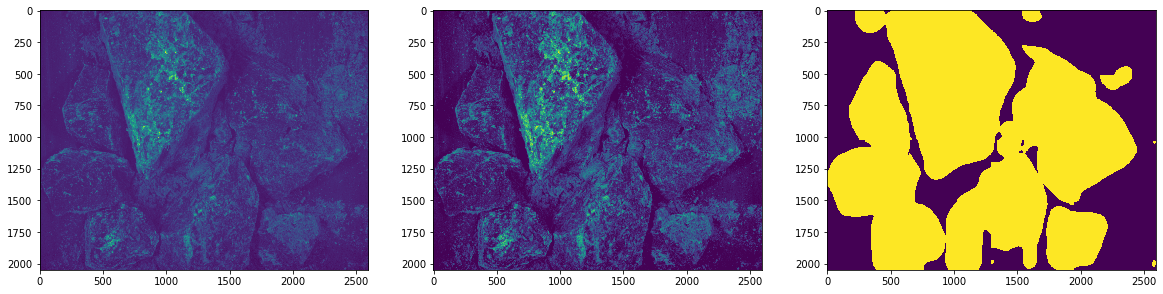

In [16]:
img = cv2.imread('asbest/tr_stones/9_12:40:22_05-03-2020_1.png', cv2.IMREAD_UNCHANGED)
# img = cv2.imread('asbest/tr_stones/1_11:32:12_16-03-2020_1.png', cv2.IMREAD_UNCHANGED)
image, mask = big_image_predict(model, img, crop_size = (img.shape[1] // 2, img.shape[0] // 2), inp_size = (448,448))
plt.figure(figsize=(20,15))
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(image)
plt.subplot(133)
plt.imshow(np.clip(mask, 0, 1) > 0.5)

In [21]:
torch.save(model, 'stone_segmentation.pth')

/home/vasily/.virtualenvs/cnn_course/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Unet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/vasily/.virtualenvs/cnn_course/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNetEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/vasily/.virtualenvs/cnn_course/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/vasily/.virtualenvs/cnn_course/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked 

In [5]:
model_load = torch.load('stone_segmentation.pth');
model_load.eval();

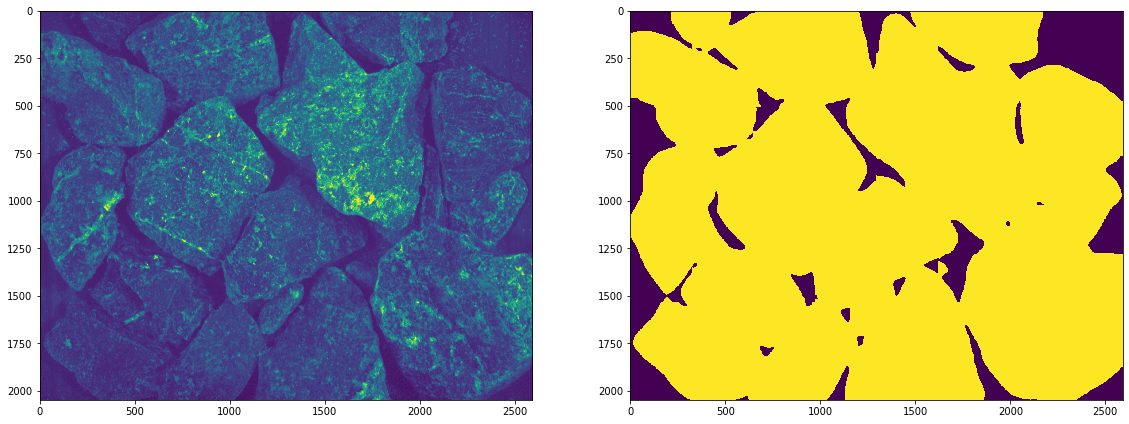

In [13]:
path_img = 'asbest/tr_stones/13_12:04:15_16-03-2020_1.png'
img = cv2.imread(path_img, cv2.IMREAD_UNCHANGED)
# img = cv2.imread('asbest/tr_stones/1_11:32:12_16-03-2020_1.png', cv2.IMREAD_UNCHANGED)
mask = big_image_predict(model_load, img, crop_size = (img.shape[1] // 4, img.shape[0] // 4), inp_size = (224,224))
plt.figure(figsize=(30,15))
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(np.clip(mask, 0, 1) > 0.5)
plt.savefig(path_img.split('/')[-1].split('_')[0] + '.png', dpi=100, bbox_inches='tight', pad_inches=0)